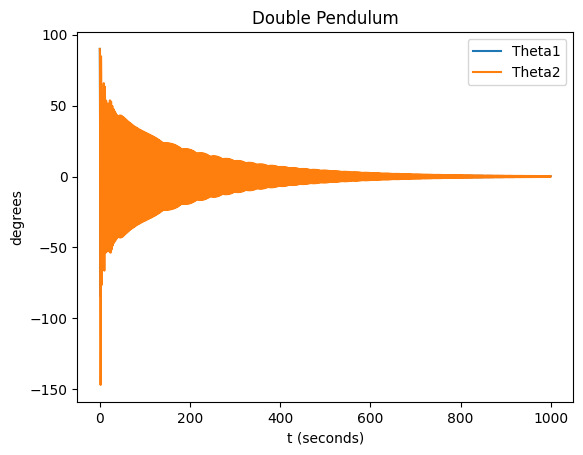

Epoch 1, Train Loss: 0.0470, Validation Loss: 0.0046
Epoch 2, Train Loss: 0.0023, Validation Loss: 0.0016
Epoch 3, Train Loss: 0.0013, Validation Loss: 0.0010
Epoch 4, Train Loss: 0.0007, Validation Loss: 0.0003
Epoch 5, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 6, Train Loss: 0.0001, Validation Loss: 0.0000
Epoch 7, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 8, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 9, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 10, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 11, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 12, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 13, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 14, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 15, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 16, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 17, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 18, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 19, Train Loss: 0.0000, Validat

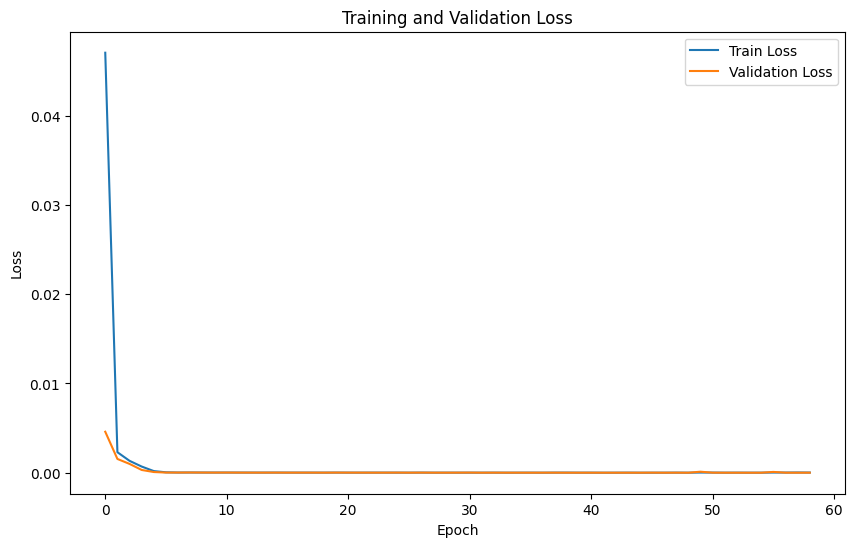

Test RMSE: 0.003266821848228574
R^2 Score: 0.9950847749951093


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array, arange, zeros_like
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score


g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0


def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]
    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2) - 2 * sin(theta1 - theta2) * m2 *
               (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))
    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1) + omega2**2 * L2 * m2 *
                                           cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))
    return array([ftheta1, fomega1, ftheta2, fomega2], float)


a = 0.0
b = 1000
N = 3000
h = (b - a) / N


tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)
q = np.array([pi / 2, 0, pi / 2, 0], float)


for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / pi
    theta2_points[i] = q[2] * 180 / pi
    k1 = h * f(q, t, L1, L2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
    k4 = h * f(q + k3, t + h, L1, L2)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6
plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.title("Double Pendulum")
plt.xlabel("t (seconds)")
plt.ylabel("degrees")
plt.legend()
plt.show()


# Combine Data
data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

# Load Data
data = np.load('pendulum_data.npy')

# Normalize Data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Create Sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create Training and Testing Sets
SEQ_LENGTH = 50
X, Y = create_sequences(data, SEQ_LENGTH)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initializing and Defining Vanilla RNN Model
class VanillaRNNModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(VanillaRNNModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        last_time_step = rnn_output[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

input_size = 2
hidden_layer_size = 100
output_size = 2

# Creating Vanilla RNN Model using dataset
model = VanillaRNNModel(input_size, hidden_layer_size, output_size)

# Weights and Biases Initialization
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)  # Xavier initialization
    elif 'bias' in name:
        nn.init.uniform_(param, -1, 1)

# Initializing loss and optimizer functions
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 100
PATIENCE = 10

# Training model with loss tracking and early stopping
train_losses = []
val_losses = []
def train_model(model, train_loader, val_loader, num_epochs, patience):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
train_model(model, train_loader, test_loader, NUM_EPOCHS, PATIENCE)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluating the model
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            y_pred = model(sequences)
            loss = torch.sqrt(loss_function(y_pred, targets))
            test_loss += loss.item()
            all_predictions.append(y_pred.numpy())
            all_targets.append(targets.numpy())
    avg_test_loss = test_loss / len(test_loader)
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    r2 = r2_score(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    print(f'Test RMSE: {rmse}')
    print(f'R^2 Score: {r2}')
evaluate_model(model, test_loader)